In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import random
import time
import os
import pandas as pd
import math
import bcolz
import pickle
import re

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
print("Pytorch: {}".format(torch.__version__))

Pytorch: 0.2.0_4


# Data loading

In [3]:
all_data_org = pd.read_csv('data/en_train_org.csv')

In [4]:
all_data_org[pd.isnull(all_data_org['before'])][:3]
all_data = all_data_org.dropna()
print("Data rows: {},  (dropped none rows: {})".format(len(all_data), len(all_data_org)-len(all_data)))

Data rows: 9918390,  (dropped none rows: 51)


In [5]:
all_data = all_data[all_data['class'] != 'VERBATIM']
print("Data rows: {},  (dropped (verbatim) rows: {})".format(len(all_data), len(all_data_org)-len(all_data)))
all_data = all_data.reset_index(drop=True)
# Note we dropped VERBATIM class. Thats because it had so many weird characters.

Data rows: 9840282,  (dropped (verbatim) rows: 78159)


In [6]:
all_data_sentence_index = all_data.set_index('sentence_id')

In [7]:
number_classes = ['DATE','CARDINAL','MEASURE','ORDINAL','DECIMAL','MONEY', 'DIGIT', 'TELEPHONE', 'TIME', 'FRACTION', 'ADDRESS']

In [8]:
number_data = all_data[all_data['class'].isin(number_classes)]
print("Data rows: {},  (dropped rows: {})".format(len(number_data), len(all_data_org)-len(number_data)))
number_data = number_data.reset_index(drop=True)

Data rows: 448176,  (dropped rows: 9470265)


In [9]:
number_data.sample(5)

,sentence_id,token_id,class,before,after
200641,335558,4,DATE,1998,nineteen ninety eight
339036,566585,7,CARDINAL,103,one hundred three
324061,542055,6,ORDINAL,12th,twelfth
414269,691284,4,DATE,28 June 1944,the twenty eighth of june nineteen forty four
327889,548472,14,MEASURE,"1""",one inch


In [10]:
number_data.groupby("class")["class"].count()

class
ADDRESS         522
CARDINAL     133744
DATE         258348
DECIMAL        9821
DIGIT          5442
FRACTION       1196
MEASURE       14783
MONEY          6128
ORDINAL       12703
TELEPHONE      4024
TIME           1465
Name: class, dtype: int64

### More balanced sample

In [11]:
balanced_data_classes_select = list(number_data.groupby('class'))
def balanced_data_randomize(max_len=10000):
    global balanced_data
    balanced_data = pd.concat([v.sample(min(max_len, len(v))) for k, v in balanced_data_classes_select])

In [12]:
%time
balanced_data_randomize()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.44 µs


In [13]:
balanced_data.groupby("class")["class"].count()

class
ADDRESS        522
CARDINAL     10000
DATE         10000
DECIMAL       9821
DIGIT         5442
FRACTION      1196
MEASURE      10000
MONEY         6128
ORDINAL      10000
TELEPHONE     4024
TIME          1465
Name: class, dtype: int64

In [64]:
balanced_data.sample(5)

,sentence_id,token_id,class,before,after
205374,343553,12,CARDINAL,"3,813",three thousand eight hundred thirteen
120708,200288,8,MONEY,"$17,708",seventeen thousand seven hundred eight dollars
330851,553311,4,DATE,10 April 1970,the tenth of april nineteen seventy
117815,195285,1,DIGIT,1,one
101375,167088,6,DECIMAL,89.0,eighty nine point zero


### Word vectors

In [15]:
def load_glove(name):
    with open(name, 'r') as f: lines = [line.split() for line in f]
    words = [d[0] for d in lines]
    vecs = np.stack(np.array(d[1:], dtype=np.float32) for d in lines)
    wordidx = {o:i for i,o in enumerate(words)}
    return vecs, words, wordidx

In [16]:
wv_vecs, wv_words, wv_idx = load_glove('/home/ohu/koodi/data/glove_wordvec/glove.6B.50d.txt')

In [17]:
re_apos = re.compile(r"(\w)'s\b")         # make 's a separate word
re_mw_punc = re.compile(r"(\w[’'])(\w)")  # other ' in a word creates 2 words
re_punc = re.compile("([\"().,;:/_?!—])") # add spaces around punctuation
re_mult_space = re.compile(r"  *")        # replace multiple spaces with just one

def simple_tokeniser(sent):
    sent = re_apos.sub(r"\1 's", sent)
    sent = re_mw_punc.sub(r"\1 \2", sent)
    sent = re_punc.sub(r" \1 ", sent).replace('-', ' - ')
    sent = re_punc.sub(r" \1 ", sent)
    sent = re_mult_space.sub(' ', sent)
    return sent.lower().split()
simple_tokeniser("asdf's   asdf   -testaaa")

['asdf', "'s", 'asdf', '-', 'testaaa']

### Number words

In [207]:
arr = list(set(list(number_data['after'])))
arr = [s.split(' ') for s in arr]
arr = np.concatenate(arr)
arr = list(set(arr))
number_words = ['<EOS>', '<SOS>'] + arr
number_words_index = dict((c, i) for i, c in enumerate(number_words))
len(number_words)

546

In [205]:
arr = list(number_data['after'])
arr = [s.split(' ') for s in arr]
arr = np.concatenate(arr)
tmp = {}
for s in arr:
    tmp[s] = tmp.get(s, 0) + 1

In [206]:
len(tmp)

544

In [110]:
arr = []
for a, b in tmp.items():
    if b > 2:
        arr.append(a)
len(arr)

312

In [210]:
print(len(number_words))
print(' - '.join(random.sample(number_words, 10)))

546
en - records - e - wednesday - 12 - ag - caribbean - yrs - double - centimeter


In [20]:
tmp = number_data[number_data['after'].str.contains('guilty')]
print(tmp['after'].iloc[0])
tmp

o six sil o nine sil o five sil gen sil re sil executive sil john sil houldsworth sil pleads sil guilty sil in sil fraud sil scheme


,sentence_id,token_id,class,before,after
406487,678277,4,TELEPHONE,06-09-05 GEN RE EXECUTIVE JOHN HOULDSWORTH PLE...,o six sil o nine sil o five sil gen sil re sil...


### Categories and Chars

In [ ]:
letters_before_all = sorted(list(set(''.join(all_data['before']))))
print(len(letters_before_all))
letters_after_all = sorted(list(set(''.join(all_data['after']))))
print(len(letters_after_all))

In [112]:
print(len(sorted(list(set(''.join(all_data['before']))))))
print(''.join(sorted(list(set(''.join(all_data['before']))))))

112
 !"#$%&'()+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyz|~¡£¥ª«²³µº»¼½¾¿éɒʻˈΩμ—€⅓⅔⅛⅝⅞


In [113]:
print(len(sorted(list(set(''.join(number_data['before']))))))
print(''.join(sorted(list(set(''.join(number_data['before']))))))

92
 "$%'(),-./0123456789:ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz£¥ª²³µº¼½¾Ωμ€⅓⅔⅛⅝⅞


In [65]:
print(len(sorted(list(set(''.join(number_data['before']).lower())))))
print(''.join(sorted(list(set(''.join(number_data['before']).lower())))))

66
 "$%'(),-./0123456789:abcdefghijklmnopqrstuvwxyz£¥ª²³µº¼½¾μω€⅓⅔⅛⅝⅞


In [114]:
tmp = sorted(list(set(''.join(number_data['before']))))
letters_all = ['<EOS>', '<SOS>'] + sorted(list(set(tmp)))
letters_all_index = dict((c, i) for i, c in enumerate(letters_all))
print(''.join(letters_all))
print(len(letters_all))

<EOS><SOS> "$%'(),-./0123456789:ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz£¥ª²³µº¼½¾Ωμ€⅓⅔⅛⅝⅞
94


In [117]:
def char_to_tensor(char): # single onehot
    tensor = torch.zeros(1, len(letters_all))
    tensor[0, letters_all_index[char]] = 1
    return tensor
print(char_to_tensor('<EOS>')[0, 0] == 1)
sos_variable = Variable(char_to_tensor('<SOS>')).cuda()

True


In [118]:
def string_to_tensor(line, include_eos=True):
    tensor_length = len(line)+1 if include_eos else len(line)
    tensor = torch.zeros(1, tensor_length, len(letters_all))
    for li, letter in enumerate(line):
        tensor[0, li, letters_all_index[letter]] = 1
    if include_eos:
        tensor[0, -1, letters_all_index['<EOS>']] = 1
    return tensor
print(string_to_tensor('wordup', include_eos=False).size())
print(string_to_tensor('wordup', include_eos=True).size())

torch.Size([1, 6, 94])
torch.Size([1, 7, 94])


### Sample

arr = [simple_tokeniser(s_)[0] for s_ in list(all_data.sample(1000)['before'])]
[s in wv_idx for s in arr].count(True) / 1000

In [128]:
def sentence_word_vectorize(str_list):
    word_vect = np.zeros((1, len(str_list), wv_vecs.shape[1]), dtype=np.float32)
    for i, w in enumerate(str_list):
        if w=='<SAMPLE>':
            word_vect[0][i] = np.zeros((1, wv_vecs.shape[1]))
        else:
            try:
                word_vect[0][i] = wv_vecs[wv_idx[w]]
            except KeyError:
                word_vect[0][i] = np.random.rand(1, wv_vecs.shape[1])
    return word_vect
sentence_word_vectorize(['and', 'here', 'she', '<SAMPLE>']).shape

(1, 4, 50)

In [220]:
def number_words_onehot(word_list, include_eos=True):
    if type(word_list) != list: raise
    tensor_length = len(word_list)+1 if include_eos else len(word_list)
    tensor = np.zeros((1, tensor_length, len(number_words)), dtype=np.float32)
    for i, w in enumerate(word_list):
        tensor[0,i,number_words_index[w]]=1
    if include_eos:
        tensor[0, -1, letters_all_index['<EOS>']] = 1
    return tensor
tmp = ['one', 'hundred']
print(number_words[np.argmax(numbers_words_onehot(tmp)[0][0])] == tmp[0])
print(number_words_onehot(tmp).shape)
print(number_words_onehot(tmp, include_eos=False).shape)
# print(numbers_words_onehot('single').shape)

True
(1, 3, 546)
(1, 2, 546)


In [236]:
number_words_onehot_sos = number_words_onehot(['<SOS>'], include_eos=False)
number_words_onehot_sos = Variable(torch.from_numpy(number_words_onehot_sos)).cuda()
number_words_onehot_sos.size()

torch.Size([1, 1, 546])

In [221]:
def get_random_sample():
    sample_row = balanced_data.iloc[random.randint(1, len(balanced_data)-1)]
    sentence_id = sample_row['class']

    #rows = all_data[all_data['sentence_id']==sample_row['sentence_id']]
    rows = all_data_sentence_index.loc[sample_row['sentence_id']]
    befores = rows.before.values
        
    token_id_idx = list(rows['token_id']).index(sample_row['token_id'])
    befores[token_id_idx] = '<SAMPLE>'
    #sentence = ' '.join(befores)
    #str_list = simple_tokeniser(sentence)
    
    #word_vect = word_vectorize(str_list)

    return sample_row['before'], sample_row['after'], sample_row['class'], befores
            
def tmp():
    # get_random_sample()
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    print(s_class, ':', s_bef, '->', s_aft)
    print(' '.join(s_sentence))
    print(sentence_word_vectorize(s_sentence).shape)
    print(number_words_onehot(s_aft.split(' ')).shape)
tmp()

MEASURE : 59 kg -> fifty nine kilograms
She represented Australia at the 2010 Commonwealth Games in free style wrestling , finishing sixth in the U / <SAMPLE> division .
(1, 22, 50)
(1, 4, 546)


In [123]:
%%timeit
get_random_sample()

427 µs ± 20.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Model functions

In [124]:
use_cuda = True

### Encoder

In [223]:
class EncoderRNN(nn.Module):
    def __init__(self, wordvect_size, chars_input_size, words_hidden_size, chars_hidden_size,
                 words_layers=1, chars_layers=1):
        super(EncoderRNN, self).__init__()

        #self.train_iterations = 0
        #self.train_history = []
        
        self.words_layers = words_layers
        self.chars_layers = chars_layers
        self.words_hidden_size = words_hidden_size
        self.chars_hidden_size = chars_hidden_size
        # self.output_size = output_size

        self.rnn_words = nn.LSTM(wordvect_size, words_hidden_size // 2, words_layers,
                                 batch_first=True, bidirectional=True)

        self.rnn_chars = nn.LSTM(chars_input_size, chars_hidden_size // 2, chars_layers,
                                batch_first=True, bidirectional=True)
        
        # self.lin_output = nn.Linear(hidden_size*2, output_size)

    def forward(self, word_vectors, string_tensor, hidden = None, init_hidden = True):
        if init_hidden:
            hidden_words, hidden_chars = self.init_hidden()
        
        all_outputs_words, hidden_words = self.rnn_words(word_vectors, hidden_words)
        output_words = all_outputs_words[:, -1]
        
        all_outputs_chars, hidden_chars = self.rnn_chars(string_tensor, hidden_chars)
        output_chars = all_outputs_chars[:, -1]
        
        output = torch.cat((output_words, output_chars), 1)
        
        # output = self.lin_output(output)
        # output = F.log_softmax(output)
        return output

    def init_hidden(self):
        var1_1 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var1_2 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var2_1 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        var2_2 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        if use_cuda:
            var1_1 = var1_1.cuda(); var1_2 = var1_2.cuda()
            var2_1 = var2_1.cuda(); var2_2 = var2_2.cuda()
        return ((var1_1, var1_2), (var2_1, var2_2))

In [317]:
def get_encoder(debug=False):
    # s_bef, s_aft, s_class, s_word_vs = get_random_sample()
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    
    s_word_vs = sentence_word_vectorize(s_sentence)
    s_string = string_to_tensor(s_bef)
    target = number_words_onehot(s_aft.split(' '))
    
    encoder_rnn = EncoderRNN(wordvect_size=s_word_vs.shape[-1], chars_input_size=len(letters_all),
                                      words_hidden_size=64, chars_hidden_size=128,
                                      words_layers=1, chars_layers=1).cuda()
    output_encoded = encoder_rnn(Variable(torch.from_numpy(s_word_vs)).cuda(), Variable(s_string).cuda())
    if debug:
        print('Word vect size:', s_word_vs.shape, '. String vector size:', s_string.size())
        print('Output:', output_encoded.size())
    return encoder_rnn, output_encoded;
encoder_rnn, output_encoded = get_encoder(debug=True)

Word vect size: (1, 16, 50) . String vector size: torch.Size([1, 4, 94])
Output: torch.Size([1, 192])


### Decoder

In [288]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(DecoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        self.rnn = nn.GRU(input_size, hidden_size, n_layers,
                                 batch_first=True, bidirectional=False)
                         # LSTM would require own hidden included
        
        self.lin_out = nn.Linear(hidden_size, input_size)
        #self.softmax = nn.LogSoftmax()

    def forward(self, char, hidden):
        #char = char.view(1,1,-1)
        #hidden = hidden.view(1,1,-1)
        output, hidden = self.rnn(char, hidden)
        output = output[:, -1] # view(1,-1)
        output = self.lin_out(output)
        output = F.log_softmax(output)
        return output, hidden

decoder_rnn = DecoderRNN(input_size=len(number_words), hidden_size=output_encoded.size()[-1])
decoder_rnn = decoder_rnn.cuda()


In [237]:
tmp_a, tmp_b = decoder_rnn(number_words_onehot_sos, output_encoded.view(1,1,-1))
print(tmp_a.size())
print(tmp_a.topk(1)[0])

torch.Size([1, 546])
Variable containing:
-6.1277
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]



In [240]:
tmp_input = number_words_onehot([number_words[tmp_a.topk(1)[1].data[0][0]]])
tmp_input = Variable(torch.from_numpy(tmp_input)).cuda()
tmp = decoder_rnn(tmp_input, tmp_b)
[t.size() for t in tmp]

[torch.Size([1, 546]), torch.Size([1, 1, 192])]

# Training etc

### Accuracy

### Training

In [241]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [267]:
"one hundred".split(' ') + ['<EOS>']

['one', 'hundred', '<EOS>']

In [377]:
def train(s_bef, s_aft, s_sentence, encoder, decoder, encoder_optimizer, decoder_optimizer, loss_function,
          use_teacher_forcing, max_length=20):

    s_word_vs = sentence_word_vectorize(s_sentence)
    s_bef_string = string_to_tensor(s_bef, include_eos=True)
    target_arr = s_aft.split(' ') + ['<EOS>']
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0

    encoder_output = encoder(Variable(torch.from_numpy(s_word_vs)).cuda(), Variable(s_bef_string).cuda())
    encoder_output = encoder_output.view(1,1,-1)
    decoder_hidden = encoder_output

    decoder_input = number_words_onehot_sos

    decoded_output = []
    for i in range(len(target_arr)):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

        decoder_target = number_words_index[target_arr[i]]
        #print(decoder_target)
        decoder_target = Variable(torch.LongTensor([decoder_target])).cuda()
        
        # import IPython; IPython.core.debugger.set_trace()
        
        loss += loss_function(decoder_output, decoder_target)

        topv, topi = decoder_output.data.topk(1)
        word_index = topi[0][0]
        word = number_words[word_index] # Use own prediction as next input
        decoded_output.append(word)
        
        if use_teacher_forcing:
            word = target_arr[i] # replace input with right target
        else:
            # use output normally as input 
            if word == '<EOS>':
                break

        decoder_input = number_words_onehot([word], include_eos=False)
        decoder_input = Variable(torch.from_numpy(decoder_input)).cuda()

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return((loss.data[0] / len(target_arr)), ' '.join(decoded_output))
#print(train())

In [368]:
encoder_rnn, output_encoded = get_encoder()
decoder_rnn = DecoderRNN(input_size=len(number_words), hidden_size=output_encoded.size()[-1]).cuda()

In [369]:
model_train_iterations = 0
model_train_history = []

In [434]:
def train_iterations(n_iters=100000, lr=0.001, teacher_forcing_ratio=0.5,
                     print_every=5000, plot_every=1000):
    global model_train_iterations
    global model_train_history
    start = time.time()
    decoder_rnn.train()
    encoder_rnn.train()

    current_loss = 0
    current_loss_iter = 0

    encoder_optimizer = torch.optim.Adam(encoder_rnn.parameters(), lr=lr)
    decoder_optimizer = torch.optim.Adam(decoder_rnn.parameters(), lr=lr)
    loss_function = nn.NLLLoss()
    
    for iteration in range(1, n_iters + 1):
        model_train_iterations += 1

        use_teacher_forcing = random.random() < teacher_forcing_ratio
        
        s_bef, s_aft, s_class, s_sentence = get_random_sample()
        
        #print(s_class, ':', s_bef, '->', s_aft, '('+str(len(s_aft))+')')
        loss, result = train(s_bef=s_bef, s_aft=s_aft, s_sentence=s_sentence,
                             encoder=encoder_rnn, decoder=decoder_rnn,
                             encoder_optimizer=encoder_optimizer, decoder_optimizer=decoder_optimizer,
                             loss_function=nn.NLLLoss(), use_teacher_forcing=use_teacher_forcing,
                             max_length=40 )

        current_loss += loss
        current_loss_iter += 1

        # Print iter number, loss, name and guess
        if iteration % print_every == 0:
            teacher_forcing_str = ""
            if use_teacher_forcing:
                teacher_forcing_str = "(forcing)"
            print("{:>6d} {:>4.0%} ({:>8}) {:>7.3f}   | {:>6.2f}: {} -> {} {} ({})".format(
                      model_train_iterations, iteration/n_iters, timeSince(start),
                      current_loss/current_loss_iter, loss,
                      s_bef, teacher_forcing_str, result, s_aft))

        # Add current loss avg to list of losses
        if iteration % plot_every == 0:
            model_train_history.append((current_loss / plot_every, lr))
            current_loss = 0
            current_loss_iter = 0
            
        if model_train_iterations % 10000 == 0:
            balanced_data_randomize()
            
        if model_train_iterations % 10000 == 0:
            save_model()
    
    # test_model_accuracy(model, n_sample=10000)
    if model_train_iterations > 1000:
        test_model_accuracy()

In [371]:
train_iterations(n_iters=1000, print_every=100, teacher_forcing_ratio=1)

   100  10% (   0m 1s)   4.482   |   4.06: 1.16MW -> (forcing) <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> (one point one six megawatts)
   200  20% (   0m 2s)   3.988   |   2.88: .1574 -> (forcing) point <EOS> <EOS> <EOS> <EOS> <EOS> (point one five seven four)
   300  30% (   0m 3s)   3.785   |   3.52: 92.1% -> (forcing) one point <EOS> <EOS> <EOS> <EOS> (ninety two point one percent)
   400  40% (   0m 4s)   3.708   |   4.05: 13 -> (forcing) two <EOS> (thirteen)
   500  50% (   0m 5s)   3.649   |   2.13: 2002 -> (forcing) one <EOS> <EOS> <EOS> (two thousand two)
   600  60% (   0m 7s)   3.562   |   2.80: .201 -> (forcing) one <EOS> <EOS> <EOS> <EOS> (point two o one)
   700  70% (   0m 8s)   3.486   |   2.76: 2.4 km -> (forcing) one hundred one <EOS> <EOS> (two point four kilometers)
   800  80% (   0m 9s)   3.432   |   2.33: 1,300 -> (forcing) nineteen hundred <EOS> <EOS> <EOS> (one thousand three hundred)
   900  90% (  0m 10s)   3.388   |   6.91: 75 hl -> (forcing) nineteen point <EOS> <

In [378]:
train_iterations(n_iters=(10000-model_train_iterations), print_every=1000, teacher_forcing_ratio=0.5)

  8239  36% (  0m 12s)   1.760   |   0.54: VIII -> (forcing) the third <EOS> (the eighth)
  9239  72% (  0m 23s)   1.602   |   1.97: 64 ->  five hundred <EOS> (sixty four)


In [379]:
train_iterations(n_iters=30000, print_every=5000, teacher_forcing_ratio=0.5)

 15000  17% (  0m 57s)   1.059   |   0.86: 84 -> (forcing) forty eight <EOS> (eight four)
 20000  33% (  1m 55s)   0.902   |   0.25: 1997 -> (forcing) nineteen ninety seven <EOS> (nineteen ninety seven)
 25000  50% (  2m 53s)   0.705   |   0.37: 8.9 km2 -> (forcing) eight point nine square kilometers <EOS> (eight point nine square kilometers)


NameError: name 'data_balance_randomize_classes' is not defined

In [381]:
train_iterations(n_iters=(30000-model_train_iterations), print_every=1000, teacher_forcing_ratio=0.4)

 26000  20% (  0m 11s)   0.738   |   1.11: 1900 ->  nineteen o <EOS> (nineteen hundred)
 27000  40% (  0m 22s)   0.768   |   0.15: 0.5/km² -> (forcing) zero point five per square kilometers <EOS> (zero point five per square kilometers)
 28000  60% (  0m 34s)   0.733   |   0.02: 44% ->  forty four percent <EOS> (forty four percent)
 29000  80% (  0m 45s)   0.710   |   0.78: 1896 ->  nineteen eighty six <EOS> (eighteen ninety six)
 30000 100% (  0m 57s)   0.683   |   2.43: $17,054 ->  seventeen thousand five hundred fifty dollars (seventeen thousand fifty four dollars)


In [386]:
train_iterations(n_iters=100, print_every=50, teacher_forcing_ratio=0.2)

Saving: data/models/numbers_gen_1_rnn_30120
Saving: data/models/numbers_gen_1_rnn_30130
Saving: data/models/numbers_gen_1_rnn_30140
Saving: data/models/numbers_gen_1_rnn_30150
 30160  50% (   0m 0s)   0.696   |   2.87: 03 - 24 ->  three sil two sil sil sil (o three sil two four)
Saving: data/models/numbers_gen_1_rnn_30160
Saving: data/models/numbers_gen_1_rnn_30170
Saving: data/models/numbers_gen_1_rnn_30180
Saving: data/models/numbers_gen_1_rnn_30190
Saving: data/models/numbers_gen_1_rnn_30200
 30210 100% (   0m 1s)   0.611   |   0.01: 3.0 ->  three point zero <EOS> (three point zero)
Saving: data/models/numbers_gen_1_rnn_30210


In [389]:
train_iterations(n_iters=(20000-(model_train_iterations%10000)), print_every=5000, teacher_forcing_ratio=0.2)

 35210  25% (  0m 58s)   0.615   |   0.00: .8 ->  point eight <EOS> (point eight)
Saving: data/models/numbers_gen_1_rnn_40000
 40210  51% (  1m 55s)   0.607   |   0.06: 2003 ->  two thousand three <EOS> (two thousand three)
 45210  76% (  2m 52s)   0.536   |   0.72: $87,498 ->  eighty four thousand eight hundred ninety eight dollars <EOS> (eighty seven thousand four hundred ninety eight dollars)
Saving: data/models/numbers_gen_1_rnn_50000


In [390]:
train_iterations(n_iters=20000, print_every=5000, teacher_forcing_ratio=0.3, lr=0.001)

 55000  25% (  0m 58s)   0.488   |   0.00: 3rd ->  third <EOS> (third)
 60000  50% (  1m 56s)   0.510   |   0.09: 1870 ->  eighteen seventy <EOS> (eighteen seventy)
Saving: data/models/numbers_gen_1_rnn_60000
 65000  75% (  2m 54s)   0.403   |   0.09: $21,118 ->  twenty one thousand one hundred eighteen dollars <EOS> (twenty one thousand one hundred eighteen dollars)
 70000 100% (  3m 51s)   0.395   |   0.01: 30 ->  thirty <EOS> (thirty)
Saving: data/models/numbers_gen_1_rnn_70000


In [391]:
train_iterations(n_iters=20000, print_every=5000, teacher_forcing_ratio=0.3, lr=0.0001)

 75000  25% (  0m 57s)   0.317   |   0.00: 9.1 ->  nine point one <EOS> (nine point one)
 80000  50% (  1m 55s)   0.324   |   0.06: 100 million ->  one hundred million <EOS> (one hundred million)
Saving: data/models/numbers_gen_1_rnn_80000
 85000  75% (  2m 53s)   0.295   |   0.26: 5:36pm ->  five thirty six p m <EOS> (five thirty six p m)
 90000 100% (  3m 51s)   0.292   |   0.13: $25,481 ->  twenty five thousand four hundred eighty one dollars <EOS> (twenty five thousand four hundred eighty one dollars)
Saving: data/models/numbers_gen_1_rnn_90000


In [392]:
train_iterations(n_iters=20000, print_every=5000, teacher_forcing_ratio=0.1, lr=0.001)

 95000  25% (  0m 57s)   0.421   |   0.66: 30 Apr. 2013 ->  the thirtieth of march twenty thirteen <EOS> (the thirtieth of april twenty thirteen)
100000  50% (  1m 55s)   0.380   |   0.00: 5th ->  fifth <EOS> (fifth)
Saving: data/models/numbers_gen_1_rnn_100000
105000  75% (  2m 53s)   0.375   |   0.22: 2011 ->  twenty eleven <EOS> (twenty eleven)
110000 100% (  3m 50s)   0.345   |   0.09: $38,485 ->  thirty eight thousand four hundred eighty five dollars <EOS> (thirty eight thousand four hundred eighty five dollars)
Saving: data/models/numbers_gen_1_rnn_110000


In [393]:
train_iterations(n_iters=20000, print_every=5000, teacher_forcing_ratio=0, lr=0.0001)

115000  25% (  0m 57s)   0.317   |   0.01: 2 million ->  two million <EOS> (two million)
120000  50% (  1m 54s)   0.299   |   0.03: $3,990 ->  three thousand nine hundred ninety dollars <EOS> (three thousand nine hundred ninety dollars)
Saving: data/models/numbers_gen_1_rnn_120000
125000  75% (  2m 52s)   0.284   |   0.28: $18,031 ->  eighteen thousand thirty one dollars <EOS> (eighteen thousand thirty one dollars)
130000 100% (  3m 49s)   0.303   |   0.01: 24 ->  twenty four <EOS> (twenty four)
Saving: data/models/numbers_gen_1_rnn_130000


In [396]:
train_iterations(n_iters=50000, print_every=5000, teacher_forcing_ratio=0.3, lr=0.001)

135000  10% (   1m 1s)   0.400   |   0.05: 0.23% -> (forcing) zero point two three percent <EOS> (zero point two three percent)
140000  20% (  1m 59s)   0.328   |   0.02: 20 ->  twenty <EOS> (twenty)
Saving: data/models/numbers_gen_1_rnn_140000
145000  30% (  2m 58s)   0.321   |   0.03: 2005 ->  two thousand five <EOS> (two thousand five)
150000  40% (  3m 57s)   0.306   |   0.09: $10.05 million ->  ten point o five million dollars <EOS> (ten point o five million dollars)
Saving: data/models/numbers_gen_1_rnn_150000
155000  50% (  4m 56s)   0.290   |   0.01: 10,000m -> (forcing) ten thousand meters <EOS> (ten thousand meters)
160000  60% (  5m 54s)   0.283   |   1.90: 47Gs -> (forcing) four seven giga hours <EOS> (forty seven giga seconds)
Saving: data/models/numbers_gen_1_rnn_160000
165000  70% (  6m 53s)   0.322   |   1.48: 978-2-04-019820-61992 -> (forcing) nine seven eight sil o sil eight eight two two two two two two nine sil nine <EOS> sil two sil sil (nine seven eight sil two si

In [417]:
test_model_accuracy()

Accuracy: 81.16% (    8116/   10000)


In [418]:
train_iterations(n_iters=50000, print_every=5000, teacher_forcing_ratio=0.2, lr=0.001)

185000  10% (  0m 58s)   0.337   |   1.47: £6,247,200 ->  six million two hundred seventy two thousand seven hundred twenty pounds (six million two hundred forty seven thousand two hundred pounds)
190000  20% (  1m 57s)   0.316   |   0.55: 2006 ->  two thousand o six (two thousand six)
Saving: data/models/numbers_gen_1_rnn_190000
195000  30% (  2m 56s)   0.280   |   0.00: 20th -> (forcing) twentieth <EOS> (twentieth)
200000  40% (  3m 54s)   0.258   |   0.10: May 13, 1919 ->  may thirteenth nineteen nineteen <EOS> (may thirteenth nineteen nineteen)
Saving: data/models/numbers_gen_1_rnn_200000
205000  50% (  4m 53s)   0.306   |   0.02: £15 ->  fifteen pounds <EOS> (fifteen pounds)
210000  60% (  5m 53s)   0.315   |   0.02: 0.00 -> (forcing) zero point o o <EOS> (zero point o o)
Saving: data/models/numbers_gen_1_rnn_210000
215000  70% (  6m 51s)   0.260   |   0.00: 1 ->  one <EOS> (one)
220000  80% (  7m 50s)   0.265   |   0.00: 1st ->  first <EOS> (first)
Saving: data/models/numbers_gen

In [419]:
train_iterations(n_iters=50000, print_every=5000, teacher_forcing_ratio=0.2, lr=0.0001)
test_model_accuracy()

235000  10% (  0m 57s)   0.234   |   0.03: 1:25 ->  one twenty five <EOS> (one twenty five)
240000  20% (  1m 57s)   0.225   |   0.86: 1965 ->  nineteen nine five five <EOS> (one nine six five)
Saving: data/models/numbers_gen_1_rnn_240000
245000  30% (  2m 55s)   0.174   |   0.03: $19,755 ->  nineteen thousand seven hundred fifty five dollars <EOS> (nineteen thousand seven hundred fifty five dollars)
250000  40% (  3m 54s)   0.189   |   0.01: $27,262 -> (forcing) twenty seven thousand two hundred sixty two dollars <EOS> (twenty seven thousand two hundred sixty two dollars)
Saving: data/models/numbers_gen_1_rnn_250000
255000  50% (  4m 52s)   0.170   |   0.00: 59th ->  fifty ninth <EOS> (fifty ninth)
260000  60% (  5m 52s)   0.177   |   0.26: 3112th -> (forcing) three thousand one hundred twelfth <EOS> (three thousand one hundred twelfth)
Saving: data/models/numbers_gen_1_rnn_260000
265000  70% (  6m 52s)   0.180   |   0.01: 17.3% ->  seventeen point three percent <EOS> (seventeen point

In [420]:
train_iterations(n_iters=50000, print_every=5000, teacher_forcing_ratio=0.3, lr=0.001)
test_model_accuracy()

285000  10% (  0m 58s)   0.257   |   1.51: 24.403 km² ->  twenty four point four o square kilometers <EOS> (twenty four point four o three square kilometers)
290000  20% (  1m 58s)   0.279   |   0.00: 2 ->  two <EOS> (two)
Saving: data/models/numbers_gen_1_rnn_290000
295000  30% (  2m 57s)   0.235   |   0.00: 30% ->  thirty percent <EOS> (thirty percent)
300000  40% (  3m 56s)   0.246   |   0.00: .166 -> (forcing) point one six six <EOS> (point one six six)
Saving: data/models/numbers_gen_1_rnn_300000
305000  50% (  4m 55s)   0.214   |   0.00: 2.09 ->  two point o nine <EOS> (two point o nine)
310000  60% (  5m 54s)   0.235   |   0.02: 8,000 ->  eight thousand <EOS> (eight thousand)
Saving: data/models/numbers_gen_1_rnn_310000
315000  70% (  6m 54s)   0.254   |   0.12: II -> (forcing) the second <EOS> (the second)
320000  80% (  7m 54s)   0.264   |   0.00: 1 ->  one <EOS> (one)
Saving: data/models/numbers_gen_1_rnn_320000
325000  90% (  8m 52s)   0.239   |   0.01: 90.31% -> (forcing) n

In [421]:
train_iterations(n_iters=50000, print_every=10000, teacher_forcing_ratio=0.3, lr=0.001)

335000  10% (  0m 58s)   0.196   |   0.01: $4,000 ->  four thousand dollars <EOS> (four thousand dollars)
340000  20% (  1m 58s)   0.177   |   0.01: 1879 ->  eighteen seventy nine <EOS> (eighteen seventy nine)
Saving: data/models/numbers_gen_1_rnn_340000
345000  30% (  2m 57s)   0.183   |   0.38: A5 -> (forcing) a five <EOS> (a five)
350000  40% (  3m 56s)   0.230   |   0.01: 1975 -> (forcing) nineteen seventy five <EOS> (nineteen seventy five)
Saving: data/models/numbers_gen_1_rnn_350000
355000  50% (  4m 55s)   0.197   |   0.05: $368,000 ->  three hundred sixty eight thousand dollars <EOS> (three hundred sixty eight thousand dollars)
360000  60% (  5m 55s)   0.218   |   0.02: 7 July ->  the seventh of july <EOS> (the seventh of july)
Saving: data/models/numbers_gen_1_rnn_360000
365000  70% (  6m 54s)   0.205   |   0.17: Jul 2015 -> (forcing) july twenty fifteen <EOS> (july twenty fifteen)
370000  80% (  7m 52s)   0.197   |   0.00: .38 ->  point three eight <EOS> (point three eight)
S

In [422]:
test_model_accuracy()

Accuracy: 84.52% (    8452/   10000)


In [424]:
train_iterations(n_iters=50000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)
test_model_accuracy()

440000  20% (  2m 10s)   0.183   |   0.01: 45 ->  forty five <EOS> (forty five)
Saving: data/models/numbers_gen_1_rnn_440000
450000  40% (  4m 21s)   0.175   |   0.06: 24 ->  two four <EOS> (two four)
Saving: data/models/numbers_gen_1_rnn_450000
460000  60% (  6m 35s)   0.178   |   0.00: 3 ->  three <EOS> (three)
Saving: data/models/numbers_gen_1_rnn_460000
470000  80% (  8m 50s)   0.141   |   2.02: 200921 ->  two o o nine two two <EOS> (two hundred thousand nine hundred twenty one)
Saving: data/models/numbers_gen_1_rnn_470000
480000 100% (  11m 3s)   0.142   |   0.00: $250,000 ->  two hundred fifty thousand dollars <EOS> (two hundred fifty thousand dollars)
Saving: data/models/numbers_gen_1_rnn_480000
Accuracy: 88.91% (    8891/   10000)


In [425]:
train_iterations(n_iters=50000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)
test_model_accuracy()

490000  20% (   2m 9s)   0.145   |   0.00: 4.61 ->  four point six one <EOS> (four point six one)
Saving: data/models/numbers_gen_1_rnn_490000
500000  40% (  4m 20s)   0.125   |   0.06: A404 ->  a four o four <EOS> (a four o four)
Saving: data/models/numbers_gen_1_rnn_500000
510000  60% (  6m 31s)   0.188   |   0.00: 30 million ->  thirty million <EOS> (thirty million)
Saving: data/models/numbers_gen_1_rnn_510000
520000  80% (  8m 43s)   0.174   |   0.00: 69 ->  sixty nine <EOS> (sixty nine)
Saving: data/models/numbers_gen_1_rnn_520000
530000 100% ( 10m 53s)   0.137   |   0.00: 14 mm ->  fourteen millimeters <EOS> (fourteen millimeters)
Saving: data/models/numbers_gen_1_rnn_530000
Accuracy: 89.81% (    8981/   10000)


In [426]:
train_iterations(n_iters=50000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)
test_model_accuracy()

540000  20% (   2m 2s)   0.132   |   0.01: 10.5 cm ->  ten point five centimeters <EOS> (ten point five centimeters)
Saving: data/models/numbers_gen_1_rnn_540000
550000  40% (   4m 3s)   0.149   |   0.01: July 17, 2012 ->  july seventeenth twenty twelve <EOS> (july seventeenth twenty twelve)
Saving: data/models/numbers_gen_1_rnn_550000
560000  60% (   6m 9s)   0.132   |   0.12: 28 April ->  the twenty eighth of april <EOS> (the twenty eighth of april)
Saving: data/models/numbers_gen_1_rnn_560000
570000  80% (  8m 11s)   0.124   |   0.00: $9,321 ->  nine thousand three hundred twenty one dollars <EOS> (nine thousand three hundred twenty one dollars)
Saving: data/models/numbers_gen_1_rnn_570000
580000 100% ( 10m 10s)   0.117   |   0.00: 2nd ->  second <EOS> (second)
Saving: data/models/numbers_gen_1_rnn_580000
Accuracy: 90.01% (    9001/   10000)


In [429]:
test_model_accuracy()

Accuracy: 90.29% (    9029/   10000)


In [435]:
train_iterations(n_iters=50000, print_every=20000, teacher_forcing_ratio=0, lr=0.001)

Saving: data/models/numbers_gen_1_rnn_640000
650000  40% (  3m 59s)   0.175   |   0.01: 8,047 ->  eight thousand forty seven <EOS> (eight thousand forty seven)
Saving: data/models/numbers_gen_1_rnn_650000
Saving: data/models/numbers_gen_1_rnn_660000
670000  80% (   8m 2s)   0.165   |   0.00: 1999 ->  nineteen ninety nine <EOS> (nineteen ninety nine)
Saving: data/models/numbers_gen_1_rnn_670000
Saving: data/models/numbers_gen_1_rnn_680000
Accuracy: 84.72% (    8472/   10000)


In [436]:
train_iterations(n_iters=50000, print_every=20000, teacher_forcing_ratio=0, lr=0.0001)

Saving: data/models/numbers_gen_1_rnn_690000
700000  40% (   4m 2s)   0.160   |   0.01: 95.3 ->  ninety five point three <EOS> (ninety five point three)
Saving: data/models/numbers_gen_1_rnn_700000
Saving: data/models/numbers_gen_1_rnn_710000
720000  80% (  7m 58s)   0.122   |   0.00: 3 ->  three <EOS> (three)
Saving: data/models/numbers_gen_1_rnn_720000
Saving: data/models/numbers_gen_1_rnn_730000
Accuracy: 89.26% (    8926/   10000)


In [438]:
train_iterations(n_iters=50000, print_every=20000, teacher_forcing_ratio=0, lr=0.0001)

Saving: data/models/numbers_gen_1_rnn_740000
750000  40% (  3m 59s)   0.135   |   0.00: 8.5% ->  eight point five percent <EOS> (eight point five percent)
Saving: data/models/numbers_gen_1_rnn_750000
Saving: data/models/numbers_gen_1_rnn_760000
770000  80% (  7m 57s)   0.135   |   0.00: 10.4 ->  ten point four <EOS> (ten point four)
Saving: data/models/numbers_gen_1_rnn_770000
Saving: data/models/numbers_gen_1_rnn_780000
Accuracy: 90.05% (    9005/   10000)


In [439]:
train_iterations(n_iters=50000, print_every=20000, teacher_forcing_ratio=0, lr=0.0001)

Saving: data/models/numbers_gen_1_rnn_790000
800000  40% (   4m 1s)   0.137   |   1.46: $640 b ->  six hundred forty pounds <EOS> (six hundred forty billion dollars)
Saving: data/models/numbers_gen_1_rnn_800000
Saving: data/models/numbers_gen_1_rnn_810000
820000  80% (   8m 9s)   0.087   |   0.00: £100,000 ->  one hundred thousand pounds <EOS> (one hundred thousand pounds)
Saving: data/models/numbers_gen_1_rnn_820000
Saving: data/models/numbers_gen_1_rnn_830000
Accuracy: 90.85% (    9085/   10000)


In [440]:
train_iterations(n_iters=50000, print_every=20000, teacher_forcing_ratio=0, lr=0.0001)

Saving: data/models/numbers_gen_1_rnn_840000
850000  40% (  3m 54s)   0.109   |   1.48: I ->  the first (one)
Saving: data/models/numbers_gen_1_rnn_850000
Saving: data/models/numbers_gen_1_rnn_860000
870000  80% (   8m 0s)   0.135   |   0.00: 1/3 ->  one third <EOS> (one third)
Saving: data/models/numbers_gen_1_rnn_870000
Saving: data/models/numbers_gen_1_rnn_880000
Accuracy: 90.84% (    9084/   10000)


# Accuracy

In [405]:
def evaluate(encoder, decoder, s_bef, s_sentence, max_length=20):
    encoder.eval()
    decoder.eval()
    s_word_vs = sentence_word_vectorize(s_sentence)
    s_bef_string = string_to_tensor(s_bef, include_eos=True)

    encoder_output = encoder(Variable(torch.from_numpy(s_word_vs)).cuda(), Variable(s_bef_string).cuda())
    encoder_output = encoder_output.view(1,1,-1)
    
    decoder_hidden = encoder_output
    decoder_input = number_words_onehot_sos

    decoded_output = []
    for _ in range(max_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

        topv, topi = decoder_output.data.topk(1)
        word_index = topi[0][0]
        word = number_words[word_index] # Use own prediction as next input
                
        if word == '<EOS>':
            break

        decoded_output.append(word)
        
        decoder_input = number_words_onehot([word], include_eos=False)
        decoder_input = Variable(torch.from_numpy(decoder_input)).cuda()

    return ' '.join(decoded_output)

evaluate(encoder_rnn, decoder_rnn, '12th', 'he was <SAMPLE>')

'twelfth'

In [432]:
def test_model_accuracy(n_sample=10000, print_wrongs=False):
    balanced_data_randomize()
    n_correct = 0
    for iteration in range(n_sample):
        s_bef, s_aft, s_class, s_sentence = get_random_sample()
        output = evaluate(encoder_rnn, decoder_rnn, s_bef, s_sentence)
        if s_aft == output:
            n_correct += 1
        else:
            if print_wrongs:
                print("{:<20} ---> {} \n{:<22} != {}".format(s_bef, output, '', s_aft))
                

    print("Accuracy: {:>4.2%} ({:>8d}/{:>8d})".format(
            n_correct/n_sample, n_correct, n_sample))

test_model_accuracy(10, print_wrongs=True)

2000-07-02           ---> the twenty of july two thousand seven 
                       != the second of july two thousand
1998-                ---> nineteen nine eight eight 
                       != one nine nine eight
Accuracy: 80.00% (       8/      10)


In [437]:
test_model_accuracy(100, print_wrongs=True)

91-85884-52-9        ---> nine one sil eight five eight five five sil five five sil nine 
                       != nine one sil eight five eight eight four sil five two sil nine
US 420               ---> s r two forty 
                       != u s four twenty
1930                 ---> nineteen thirty 
                       != one nine three o
2001-08-24           ---> the twenty fourth of april two thousand 
                       != the twenty fourth of august two thousand one
1998                 ---> nineteen thousand nine hundred ninety eight 
                       != one thousand nine hundred ninety eight
0066 - EN            ---> o o six six sil 
                       != o o six six sil en
0000 UTC             ---> o o o o u u c 
                       != o o o o sil u t c
Accuracy: 93.00% (      93/     100)


# Saving the model

In [385]:
def save_model():
    saved_model_path = 'data/models/numbers_gen_1_rnn_' + str(model_train_iterations)
    print("Saving:", saved_model_path)
    torch.save(decoder_rnn.state_dict(), saved_model_path+'_decoder')
    torch.save(encoder_rnn.state_dict(), saved_model_path+'_encoder')

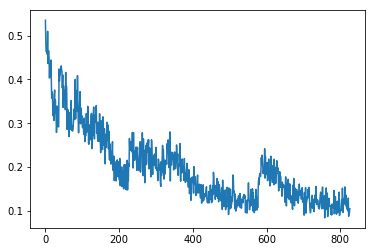

In [449]:
plt.figure()
plt.plot(np.array(model_train_history)[:, 0][50:])